In [1]:
"""
Evaluator–Optimizer Workflow (상세페이지 자동 생성용)
---------------------------------------------------
- LangGraph StateGraph + 명시적 State 타입(TypedDict)
- Generator / Evaluator (Feedback 흡수) 2-노드 구조
- 비용 최적화: gpt-4o-mini
- 프롬프트 외부 .md 파일 분리
- 조건부 전이 + (필요 시) Command/Send로 직접 재호출
"""

from typing import TypedDict, Optional, Dict, Any, List
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, Send
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field, ConfigDict
import json
import os


# =========================================================
# 모델 설정 (비용 효율)
# =========================================================
GEN_MODEL = "gpt-4o-mini"
EVAL_MODEL = "gpt-4o-mini"

llm_generator = ChatOpenAI(model=GEN_MODEL, temperature=0.7)
llm_evaluator = ChatOpenAI(model=EVAL_MODEL, temperature=0.3)

# =========================================================
# 헬퍼 - 프롬프트 로더
# =========================================================
GEN_PROMPT_PATH = "./prompts/generator_prompt.md"
EVAL_PROMPT_PATH = "./prompts/evaluator_prompt.md"


def load_prompt(path: str) -> str:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Prompt file not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        return f.read().strip()

In [2]:
# =========================================================
# 2) 평가 결과 스키마
# =========================================================
class Violation(BaseModel):
    text: str = Field(description="문제 되는 원문 또는 요지")
    reason: str = Field(description="위반 사유")
    model_config = ConfigDict(extra="forbid")  # ← 추가Properties false


class EvalResult(BaseModel):
    score: float = Field(..., ge=0, le=100)
    passed: bool = Field(..., alias="pass")
    revise_instructions: List[str] = Field(default_factory=list)
    violations: List[Violation] = Field(default_factory=list)
    model_config = ConfigDict(extra="forbid")  # ← 추가Properties false

# =========================================================
# 1) State 정의
# =========================================================


class State(TypedDict):
    meta: Dict[str, Any]                  # 제품 메타정보 (입력)
    draft: Optional[str]                  # Generator 결과 (초안)
    evaluation: EvalResult  # Evaluator JSON 평가 결과
    feedback: Optional[str]               # 수정 지시사항(누적/최신)
    iteration: int                        # 루프 카운트
    reference_page_text_array: [str]

In [3]:
# - **참고상세페이지** : {state["meta"]["reference_page_text_array"]}
#     **참고상세페이지**는 기존 상세페이지에서 추출한 텍스트 배열 입니다. 제품의 특징/장점 등을 참고하여 상세페이지 초안을 작성하세요.
# =========================================================
# 1) 노드: Generator
# =========================================================
def node_generate(state: State) -> State:
    prompt = f"""
    다음 제품에 대한 상세페이지 초안을 작성하세요.

    - 제품명: {state["meta"]["product_name"]}
    - 타깃: {state["meta"]["target_audience"]}
    - 키워드: {", ".join(state["meta"]["seo_keywords"])}
    - 인증: {state["meta"]["certs_or_tests"]}
    - 금지어: {", ".join(state["meta"]["banned_terms"])}

    

    구성:

    1. Hook
    2. 3 Key Benefits
    3. Specs
    4. Usage
    5. Care & Notice
    6. FAQ
    7. CTA

    톤: 신뢰감 있고 친근하게
    Hook를 25자 이내로 축약하고 핵심 효익을 문장 첫머리에 배치
    이전 피드백: {state["feedback"]}
    """

    resp = llm_generator.invoke(prompt)
    return {**state, "draft": resp.content, "iteration": state["iteration"] + 1}

# =========================================================
# 2) 노드: Evaluator (피드백 생성까지 수행)
#    - 조건: 통과/최대루프 → 상태만 반환 (조건부 전이로 END)
#    - 조건: 미통과 → Command/Send로 Generator 재호출 (Feedback 별도 노드 불필요)
# =========================================================


def node_evaluate(state: State):
    prompt = f"""
        다음은 {state["meta"]["product_name"]}의 상세페이지 초안입니다.
        이를 루브릭 기준으로 평가하고 **JSON 형식으로만** 결과를 반환하세요. 추가 설명, 접두/접미 문장, 코드펜스(```), 마크다운, 주석은 모두 금지합니다. **JSON 이외의 어떤 텍스트도 출력하지 마세요.**

        평가 항목(예시): 구조 준수, 혜택 명확성, 규정 위반(과장·질병치료 표현 등), 브랜드 톤, 가독성, SEO/포맷(표·단위·ALT), CTA, 접근성.
        점수(0~100)는 종합 품질을 반영하며, 합격 기준은 score ≥ 90이고 동시에 위반(violations)이 없어야 합니다.

        반드시 아래 **JSON 스키마**에 맞춰 출력하세요(키/타입/스펠링 고정):
        {{
        "score": number,                  // 0 이상 100 이하 정수 또는 소수
        "pass": boolean,                  // true/false (합격 여부)
        "revise_instructions": [string],  // 구체적 수정 지시사항(명령문) 배열, 길이 1~10
        "violations": [                   // 위반 항목 배열(없으면 빈 배열)
            {{
            "text": string,               // 문제 되는 원문 또는 요지
            "reason": string              // 왜 위반인지 간단한 근거(정책/규정 포인트)
            }}
        ]
        }}

        제약:
        - "revise_instructions"는 **실행 가능한 명령문**으로만 작성(예: "Hook를 25자 이내로 축약하고 핵심 효익을 문장 첫머리에 배치").
        - "violations"에는 과장/질병치료/허위 비교/경쟁사 언급/필수 고지 누락 등 실제 위반만 기록. 경미한 개선사항은 violations가 아니라 "revise_instructions"로만 제시.
        - JSON 외 텍스트/마크다운/문맥 설명 금지.

        평가 대상 초안:
        {state["draft"]}
    """

    structured_llm_evaluator = llm_evaluator.with_structured_output(
        EvalResult)  # , method="function_calling"
    response: EvalResult = structured_llm_evaluator.invoke(prompt)

    # evaluation = response.model_dump(by_alias=True)

    print("*" * 50)
    print(response)
    print("=" * 50)

    # Evaluator가 피드백 생성까지 수행
    feedback_text = "\n".join(
        response.revise_instructions) if response.revise_instructions else None

    updated: State = {
        **state,
        "evaluation": response,
        "feedback": feedback_text,
    }

    # 통과 또는 최대 루프 → 상태만 반환(그래프 조건부 전이로 END)
    # if (evaluation.get("passed") and evaluation.get("score", 0) >= 90) or (state["iteration"] >= 3):
    if (response.passed and response.score >= 90) or (state["iteration"] >= 3):
        return updated

    # 미통과 → Command를 사용해 즉시 Generator 재호출
    return Command(
        goto="Generator",
        update=updated
    )

# =========================================================
# 2) 상태 전이 조건 (Evaluator 이후 전이만 정의)
#    - node_evaluate에서 Command/Send로 재호출한 경우 조건 전이는 무시됨
#    - 상태만 반환된 경우에만 조건 전이가 적용
# =========================================================


def route_after_eval(state: State) -> str:
    evaluation = state["evaluation"]
    if (evaluation.passed and evaluation.score >= 90) or (state["iteration"] >= 3):
        return "Accepted"
    # 일반적으로 여기 도달하지 않음(미통과 시 evaluator가 Command/Send 사용)
    return "Rejected+Feedback"

In [4]:
# =========================================================
# 그래프 빌드
# =========================================================
graph_builder = StateGraph(State)

graph_builder.add_node("Generator", node_generate)
graph_builder.add_node("Evaluator", node_evaluate)

graph_builder.add_edge(START, "Generator")
graph_builder.add_edge("Generator", "Evaluator")
graph_builder.add_edge("Evaluator", END)

# Evaluator가 상태만 반환(accept/maxed)한 경우에만 END로 전이
graph_builder.add_conditional_edges(
    "Evaluator",
    route_after_eval,
    {
        "Accepted": END,
        # 안전망(보통 미사용) — evaluator가 Command/Send 실패 시 사용
        "Rejected+Feedback": "Generator",
    },
)

graph = graph_builder.compile()

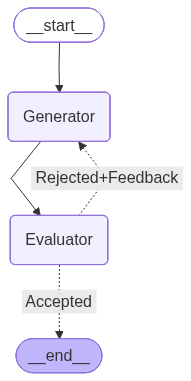

In [5]:
graph

In [ ]:
# graph

from pprint import pprint
meta_info = {
    "product_name": "하이퍼미디어 구멍이 뚤려 있는 다이어트용 수저",
    "target_audience": "다이어트를 하는 사람들 / 저염식을 주로 먹는 사람들, 운동하는 사람들, 건강을 중요하게 생각하는 사람들, 고혈압/당뇨 를 관리 해야 하는 사람들",
    "seo_keywords": ["다이어트", "저염식", "운동", "건강", "고혈압", "당뇨"],
    "certs_or_tests": "KC인증, 식약처 인증",
    "banned_terms": ["100%", "자연유래", "친환경", "과대포장", "허위광고"],
    "reference_page_text_array": [],
}

initial_state: State = {
    "meta": meta_info,
    "draft": None,
    "evaluation": None,
    "feedback": None,
    "iteration": 0,
}

# ✅ Jupyter 실시간 출력 (Streaming)

# stream 결과를 저장해서 마지막 상태 사용
final_chunks = []
for chunk in graph.stream(initial_state, stream_mode="updates"):
    print("=====================\n", chunk, "\n")
    final_chunks.append(chunk)

# 마지막 chunk에서 상태 추출
if final_chunks:
    last_chunk = final_chunks[-1]
    final_state = list(last_chunk.values())[0]  # 마지막 노드의 상태
    print("\n✅ 최종 결과:")
    pprint(final_state)